# Quantization Neural Network with Eve

In this script, we will build a quantization neural network with eve-mli,
different kinds of quantization function will be compared.

In [1]:
# import necessary packages.
# at the beginning, ensure that the eve-mli package is in your python path.
# or you just install it via `pip install eve-mli`.

import os
import time
from datetime import datetime

import random
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import eve
import eve.app
import eve.app.model
import eve.app.trainer
import eve.core
import eve.app.space as space
import eve.core.layer
import eve.core.quan

from matplotlib import pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
# build a basic network for trainer, use Poisson Encoder as default
class mnist(eve.core.Eve):
    def __init__(self,
            quan_on_a: bool = True,
            quan_on_w: bool = True,
            bits: int = 8,
            quantize_fn: str = "Round",
            range_tracker: str = "average_tracker",
            average_tracker_momentum: float = 0.1,
            upgrade_bits: bool = False,
            neuron_wise: bool = False,
            asymmetric: bool = False,
            signed_quantization: bool = False,
            learnable_alpha: bool = None,
            upgrade_fn: callable = None,
            **kwargs,):
        super().__init__()
 
        def build_quantizer(state):
            return eve.core.quan.Quantizer(state, 
                         bits = bits,
                         quantize_fn = quantize_fn,
                         range_tracker = range_tracker,
                         average_tracker_momentum = average_tracker_momentum,
                         upgrade_bits = upgrade_bits,
                         neuron_wise = neuron_wise,
                         asymmetric = asymmetric,
                         signed_quantization = signed_quantization,
                         learnable_alpha = learnable_alpha,
                         upgrade_fn = upgrade_fn,
                         **kwargs,)
        if quan_on_w:
            self.conv1 = eve.core.layer.QuanBNFuseConv2d(1, 4, 3, stride=2, padding=1)
            self.conv1.assign_quantizer(
                build_quantizer(eve.core.State(self.conv1, apply_on="param")))
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(1, 4, 3, stride=2, padding=1), nn.BatchNorm2d(4))
        self.relu1 = nn.ReLU()
        if quan_on_a:
            self.act_quan1 = build_quantizer(eve.core.State(self.conv1, apply_on="data"))
        else:
            self.act_quan1 = nn.Sequential()

        if quan_on_w:
            self.conv2 = eve.core.layer.QuanBNFuseConv2d(4, 8, 3, stride=2, padding=1)
            self.conv2.assign_quantizer(
                build_quantizer(eve.core.State(self.conv2, apply_on="param")))
        else:
            self.conv2 = nn.Sequential(nn.Conv2d(4, 8, 3, stride=2, padding=1), nn.BatchNorm2d(8))
        self.relu2 = nn.ReLU()
        if quan_on_a:
            self.act_quan2 = build_quantizer(eve.core.State(self.conv2, apply_on="data"))
        else:
            self.act_quan2 = nn.Sequential()
            
        if quan_on_w:
            self.conv3 = eve.core.layer.QuanBNFuseConv2d(8, 16, 3, stride=2, padding=1)
            self.conv3.assign_quantizer(
                build_quantizer(eve.core.State(self.conv3, apply_on="param")))
        else:
            self.conv3 = nn.Sequential(nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.BatchNorm2d(16))
        self.relu3 = nn.ReLU()
        if quan_on_a:
            self.act_quan3 = build_quantizer(eve.core.State(self.conv3, apply_on="data"))
        else:
            self.act_quan3 = nn.Sequential()

        if quan_on_w:
            self.linear1 = eve.core.layer.QuanLinear(16 * 4 * 4, 16)
            self.linear1.assign_quantizer(
                build_quantizer(eve.core.State(self.linear1, apply_on="param")))
        else:
            self.linear1 = nn.Linear(16 * 4 * 4, 16)
        self.relu4 = nn.ReLU()
        if quan_on_a:
            self.act_quan4 = build_quantizer(eve.core.State(self.linear1, apply_on="data"))
        else:
            self.act_quan4 = nn.Sequential()
        
        self.linear2 = nn.Linear(16, 10)

    def forward(self, x):
        conv1 = self.conv1(x)
        relu1 = self.relu1(conv1)
        act_quan1 = self.act_quan1(relu1)

        conv2 = self.conv2(act_quan1)
        relu2 = self.relu2(conv2)
        act_quan2 = self.act_quan2(relu2)

        conv3 = self.conv3(act_quan2)
        relu3 = self.relu3(conv3)
        act_quan3 = self.act_quan3(relu3)

        act_quan3 = th.flatten(act_quan3, start_dim=1).unsqueeze(dim=1)

        linear1 = self.linear1(act_quan3)
        relu4 = self.relu4(linear1)
        act_quan4 = self.act_quan4(relu4)

        linear2 = self.linear2(act_quan4)

        return linear2.squeeze(dim=1)

In [3]:
# define a MnistClassifier
# Classifier uses the corss entropy as default.
# in most case, we just rewrite the `prepare_data`.
class MnistClassifier(eve.app.model.Classifier):
    def prepare_data(self, data_root: str):
        from torch.utils.data import DataLoader, random_split
        from torchvision import transforms
        from torchvision.datasets import MNIST

        train_dataset = MNIST(root=data_root,
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())
        test_dataset = MNIST(root=data_root,
                             train=False,
                             download=True,
                             transform=transforms.ToTensor())
        self.train_dataset, self.valid_dataset = random_split(
            train_dataset, [55000, 5000])
        self.test_dataset = test_dataset

        self.train_dataloader = DataLoader(self.train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=4)
        self.test_dataloader = DataLoader(self.test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=4)
        self.valid_dataloader = DataLoader(self.valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=4)

In [4]:
# store accuracy result
y = {}
def plot():
    global y
    keys, values = list(y.keys()), list(y.values())
    for k, v in y.items():
        plt.plot(v, 
                 color='green' if random.random() > 0.5 else "red", 
                 marker='o' if random.random() > 0.5 else "*", 
                 linestyle='-' if random.random() > 0.5 else ":", 
                 label=k)
    plt.title('accuracy over epoches (train)')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc="upper left")
    plt.show()

In [5]:
def train(net, exp_name: str = "quan", data_root: str = "/home/densechen/dataset"):
    global y
    # replace the data_root for your path.
    classifier = MnistClassifier(net)
    classifier.prepare_data(data_root=data_root)
    
    # use default configuration
    # use a smaller lr for that alpha is unstable during training
    classifier.setup_train(lr=1e-4)
    
    # assign model to trainer
    eve.app.trainer.BaseTrainer.assign_model(classifier)
    
    trainer = eve.app.trainer.BaseTrainer()
    
    # train 10 epoches and report the final accuracy
    y[exp_name] = []
    tic = datetime.now()
    for _ in range(10):
        info = trainer.fit()
        y[exp_name].append(info["acc"])
    info = trainer.test()
    toc = datetime.now()
    y[exp_name] = np.array(y[exp_name])
    print(f"Test Accuracy: {info['acc']*100:.2f}%, Elapsed time: {toc-tic}")

## Quan param vs Quan act

===> Quantization on param
Test Accuracy: 83.58%, Elapsed time: 0:01:41.564670
===> Quantization on act
Test Accuracy: 96.52%, Elapsed time: 0:01:15.718537
===> Quantization on both
Test Accuracy: 83.30%, Elapsed time: 0:02:08.939456
===> Quantization on neither
Test Accuracy: 96.59%, Elapsed time: 0:00:46.188178


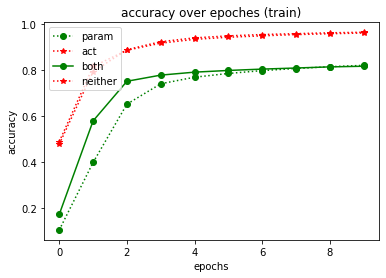

In [6]:
# reset y
y = {}

# define quantization neural network with quantize param, quantize act and quantize on both
quantization_neural_network_param = mnist(quan_on_w=True, quan_on_a=False).quantize()
quantization_neural_network_act = mnist(quan_on_w=False, quan_on_a=True).quantize()
quantization_neural_network_both = mnist(quan_on_w=True, quan_on_a=True).quantize()
quantization_neural_network_neither = mnist(quan_on_w=False, quan_on_a=False).quantize()
# or
# quantization_neural_network_neither = mnist().non_quanitze()

print("===> Quantization on param")
train(quantization_neural_network_param, "param")

print("===> Quantization on act")
train(quantization_neural_network_act, "act")

print("===> Quantization on both")
train(quantization_neural_network_both, "both")

print("===> Quantization on neither")
train(quantization_neural_network_neither, "neither")

plot()

## Round vs LSQ vs LLSQ on act only

===> Quantization with Round
Test Accuracy: 95.72%, Elapsed time: 0:01:14.043124
===> Quantization with lsq
Test Accuracy: 94.90%, Elapsed time: 0:01:24.896148
===> Quantization with llsq_l1
Test Accuracy: 95.08%, Elapsed time: 0:02:05.949373
===> Quantization with llsq_l2
Test Accuracy: 95.35%, Elapsed time: 0:02:11.568797


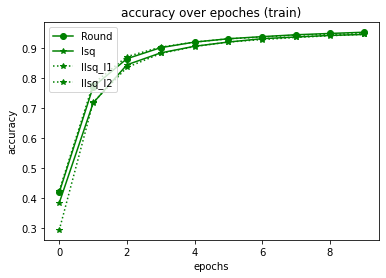

In [12]:
# reset y
y = {}

# define quantization neural network with different quantization function
quantization_neural_network_round = mnist(quan_on_w=False, quantize_fn="Round").quantize()
quantization_neural_network_lsq = mnist(quan_on_w=False, quantize_fn="Lsq").quantize()
quantization_neural_network_llsq_l1 = mnist(quan_on_w=False, quantize_fn="Llsq", regular="l1").quantize()
quantization_neural_network_llsq_l2 = mnist(quan_on_w=False, quantize_fn="Llsq", regular="l2").quantize()

print("===> Quantization with Round")
train(quantization_neural_network_round, "Round")

print("===> Quantization with lsq")
train(quantization_neural_network_lsq, "lsq")

print("===> Quantization with llsq_l1")
train(quantization_neural_network_llsq_l1, "llsq_l1")

print("===> Quantization with llsq_l2")
train(quantization_neural_network_llsq_l2, "llsq_l2")

plot()

## Average tracker vs Global tracker

===> Quantization with average range tracker
Test Accuracy: 82.03%, Elapsed time: 0:02:10.593734
===> Quantization with global range tracker
Test Accuracy: 84.06%, Elapsed time: 0:02:12.500429


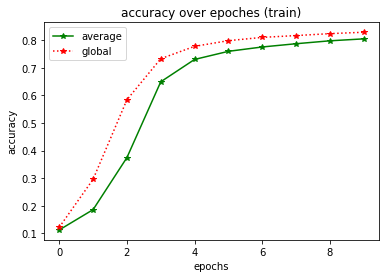

In [8]:
# reset y
y = {}

# define quantization neural network with different quantization function
quantization_neural_network_average_tracker = mnist(range_tracker="average_tracker").quantize()
quantization_neural_network_global_tracker = mnist(range_tracker="global_tracker").quantize()

print("===> Quantization with average range tracker")
train(quantization_neural_network_average_tracker, "average")

print("===> Quantization with global range tracker")
train(quantization_neural_network_global_tracker, "global")

plot()

## Round with with different bits¶

===> Quantization with 2 bits
Test Accuracy: 45.51%, Elapsed time: 0:02:10.259819
===> Quantization with 4 bits
Test Accuracy: 71.16%, Elapsed time: 0:02:08.941098
===> Quantization with 8 bits
Test Accuracy: 81.84%, Elapsed time: 0:02:07.281995
===> Quantization with full precision
Test Accuracy: 96.11%, Elapsed time: 0:01:40.056623


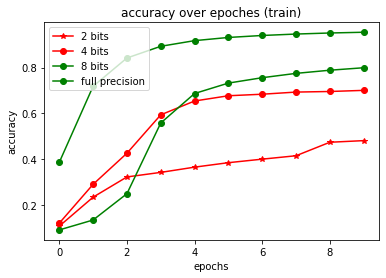

In [9]:
# reset y
y = {}

# define quantization neural network with different configuration
quantization_neural_network_bits_2 = mnist(bits=2).quantize()
quantization_neural_network_bits_4 = mnist(bits=4).quantize()
quantization_neural_network_bits_8 = mnist(bits=8).quantize()
quantization_neural_network_full_precision = mnist().non_quantize()

print("===> Quantization with 2 bits")
train(quantization_neural_network_bits_2, "2 bits")

print("===> Quantization with 4 bits")
train(quantization_neural_network_bits_4, "4 bits")

print("===> Quantization with 8 bits")
train(quantization_neural_network_bits_8, "8 bits")

print("===> Quantization with full precision")
train(quantization_neural_network_full_precision, "full precision")

plot()

## quan with other arguments

===> Quantization with neuron wise
Test Accuracy: 95.60%, Elapsed time: 0:01:39.704981
===> Quantization with neuron share
Test Accuracy: 95.79%, Elapsed time: 0:01:48.575900
===> Quantization with asymmetric
Test Accuracy: 95.84%, Elapsed time: 0:01:32.690768
===> Quantization with symmetric
Test Accuracy: 96.14%, Elapsed time: 0:01:42.991659
===> Quantization with signed quantization
Test Accuracy: 95.88%, Elapsed time: 0:01:51.287698
===> Quantization with unsigned quantization
Test Accuracy: 95.60%, Elapsed time: 0:01:36.948094


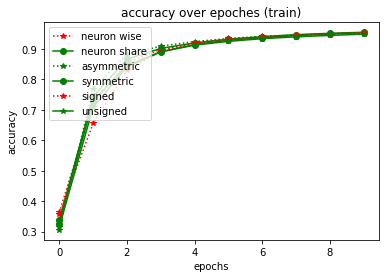

In [13]:
# reset y
y = {}

# define quantization neural network
quantization_neural_network_neuron_wise = mnist(neuron_wise=True)
quantization_neural_network_neuron_share = mnist(neuron_wise=False)

quantization_neural_network_asymmetric = mnist(asymmetric=True)
quantization_neural_network_symmetric = mnist(asymmetric=False)

quantization_neural_network_signed_quantization = mnist(signed_quantization=True)
quantization_neural_network_unsigned_quantization = mnist(signed_quantization=False)

print("===> Quantization with neuron wise")
train(quantization_neural_network_neuron_wise, "neuron wise")

print("===> Quantization with neuron share")
train(quantization_neural_network_neuron_share, "neuron share")

print("===> Quantization with asymmetric")
train(quantization_neural_network_asymmetric, "asymmetric")

print("===> Quantization with symmetric")
train(quantization_neural_network_symmetric, "symmetric")

print("===> Quantization with signed quantization")
train(quantization_neural_network_signed_quantization, "signed")

print("===> Quantization with unsigned quantization")
train(quantization_neural_network_unsigned_quantization, "unsigned")

plot()